run tensorboard with `tensorboard --logdir=runs --bind_all`

In [1]:
# torch loaded...!!!
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard.writer import SummaryWriter
from torch.utils.data import Dataset, DataLoader, random_split

# torchvision loaded...!!!
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchinfo import summary

# matplotlib loaded...!!!
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from datetime import datetime
from tqdm import tqdm

In [2]:
plt.style.use("dark_background")

### **2.Define Constants**

In [3]:
# Constants
TESTING = False
NUM_EPOCHS = 3
LEARNING_RATE = 0.001
BATCH_SIZE = 32
NOISE_FACTOR = 0.0  # constant NOISE_FACTOR which defines the amount of noise that we will add to our images.

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


### **3.Prepare the Data**

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))]
)

### **4.Data Loader and Download**

In [6]:
class FMNISTODataset(Dataset):
    def __init__(self, images, n):
        self.n = n
        # Ensure images is a torch Tensor for consistency
        if isinstance(images, torch.Tensor):
            self.images = images
        else:
            self.images = torch.tensor(images, dtype=torch.float32).view(1, 28, 28)

        # Duplicate each image n times
        self.duplicated_images = self.images.repeat_interleave(n, dim=0)

    def __len__(self):
        return len(self.duplicated_images)

    def __getitem__(self, idx):
        return self.duplicated_images[idx]

In [7]:
class MIDILoopDataset(Dataset):
    def __init__(
        self,
        data,
        transforms=None,
    ):
        self.data = data
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        name, image = self.data[idx]
        image = self.format_image(image)
        if self.transforms:
            image = self.transforms(image)
        return name, image

    def format_image(self, image, remove_time=True):
        if remove_time:
            image = np.delete(image, 0, axis=1)
        image = torch.from_numpy(np.expand_dims(image, 0)).to(torch.float32)
        if torch.any(image > 1.0):
            image = image / image.max()
        image = F.pad(input=image, pad=(0, 12, 1, 1), mode="constant", value=0.0)

        return image

In [8]:
if TESTING:
    # Download the FashionMNIST dataset
    trainset = torchvision.datasets.FashionMNIST(
        root="./data_new", train=True, download=True, transform=transform
    )
    testset = torchvision.datasets.FashionMNIST(
        root="./data_new", train=False, download=True, transform=transform
    )
    overfitset = FMNISTODataset(trainset[0][0], 3200)

    # Load the dataset in the dataloader
    trainLoader = torch.utils.data.DataLoader(
        trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4
    )
    testLoader = torch.utils.data.DataLoader(
        testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
    )
    overfitLoader = DataLoader(
        overfitset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
    )
else:
    input_dataset = np.load("data/all_loops.npz")
    inputset = MIDILoopDataset(list(input_dataset.items()))
    overfitset = MIDILoopDataset([list(input_dataset.items())[0]] * 3200)
    trainset, testset = random_split(inputset, [0.8, 0.2])

    trainLoader = DataLoader(
        trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4
    )
    testLoader = DataLoader(
        testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
    )
    overfitLoader = DataLoader(
        overfitset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
    )

In [9]:
for batch in overfitLoader:
    batch1 = batch
    break

if TESTING:
    print(batch1[0].shape)
else:
    print(batch1[1].shape)

torch.Size([32, 1, 60, 412])


### **5.Some Helper Function**

In [10]:
def make_dir():
    image_dir = "Saved_Images"
    if not os.path.exists(image_dir):
        os.mkdir(image_dir)


def save_decoded_image(img, name):
    if TESTING:
        img = img.view(img.size(0), 1, 28, 28)
    else:
        img = img.view(img.size(0), 1, 60, 412)
    save_image(img, "Saved_Images/" + name + ".png")

In [11]:
def plot_image(image, title, set_axis="off"):
    plt.imshow(
        np.squeeze(image),
        aspect="auto",
        origin="lower",
        cmap="magma",
        interpolation="nearest",
    )
    plt.title(title)
    plt.axis(set_axis)
    plt.show()

In [12]:
def plot_images(images, titles, set_axis="off"):
    num_images = len(images)
    for num_plot in range(num_images):
        plt.subplot(num_images, 1, num_plot + 1)
        plt.imshow(
            np.squeeze(images[num_plot]),
            aspect="auto",
            origin="lower",
            cmap="magma",
            interpolation="nearest",
        )
        plt.title(titles[num_plot])
        plt.axis(set_axis)

    plt.show()

### **6.Define the AutoEncoder Neural Network**

In [13]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Encoder layers
        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Decoder layers
        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)
        self.dec2 = nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2)
        self.dec3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        self.out = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        x = self.pool(F.silu(self.enc1(x)))
        x = self.pool(F.silu(self.enc2(x)))
        x = self.pool(F.silu(self.enc3(x)))
        x = self.pool(F.silu(self.enc4(x)))  # latent space representation

        # Decoder
        x = F.silu(self.dec1(x))
        x = F.silu(self.dec2(x))
        x = F.silu(self.dec3(x))
        x = F.silu(self.dec4(x))
        # x = torch.sigmoid(self.out(x))
        x = self.out(x)

        return x


model = AutoEncoder().to(device)

In [14]:
print(model)

AutoEncoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [15]:
if TESTING:
    print(summary(model, (1, 28, 28)))
else:
    print(summary(model, (1, 58, 400)))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 60, 412]              --
├─Conv2d: 1-1                            [64, 58, 400]             640
├─MaxPool2d: 1-2                         [64, 29, 200]             --
├─Conv2d: 1-3                            [32, 29, 200]             18,464
├─MaxPool2d: 1-4                         [32, 14, 100]             --
├─Conv2d: 1-5                            [16, 14, 100]             4,624
├─MaxPool2d: 1-6                         [16, 7, 50]               --
├─Conv2d: 1-7                            [8, 7, 50]                1,160
├─MaxPool2d: 1-8                         [8, 3, 25]                --
├─ConvTranspose2d: 1-9                   [8, 7, 51]                584
├─ConvTranspose2d: 1-10                  [16, 15, 103]             1,168
├─ConvTranspose2d: 1-11                  [32, 30, 206]             2,080
├─ConvTranspose2d: 1-12                  [64, 60, 412]             

### **7. Optimizer and Loss Function**

In [16]:
# the loss function
loss_fn = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### **8.Defining the training and test function**

In [17]:
def train(net, trainLoader, num_epochs=NUM_EPOCHS, logging=True):
    train_loss = []
    if logging:
        writer = SummaryWriter(
            f"runs/{datetime.now().strftime('%y-%m-%d_%H%M%S')}_reset"
        )
    for epoch in range(num_epochs):
        running_loss = 0.0
        with tqdm(trainLoader, unit="batch") as tepoch:
            for i, data in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch+1:02d}")
                if TESTING:
                    img = data.view(32, 1, 28, 28)
                else:
                    name, img = data
                # add noise to the image data
                img_noisy = img + NOISE_FACTOR * torch.randn(img.shape)
                # clip to make the values fall between 0 and 1
                img_noisy = np.clip(img_noisy, 0.0, 1.0)
                img_noisy = img_noisy.to(device)
                optimizer.zero_grad()
                outputs = net(img_noisy)

                loss = loss_fn(outputs, img_noisy)
                # backpropagation
                loss.backward()
                # update the parameters
                optimizer.step()
                running_loss += loss.item()
                tepoch.set_postfix(loss=f"{loss.item():03f}")

                if logging:
                    global_step = epoch * len(trainLoader) + i
                    writer.add_scalar("training/loss", loss.item(), global_step)
                    for p_name, param in model.named_parameters():
                        writer.add_histogram(
                            f"weights/{p_name}", param.data, global_step
                        )
                        if param.requires_grad:
                            writer.add_histogram(
                                f"gradients/{p_name}.grad", param.grad, global_step
                            )

            loss = running_loss / len(trainLoader)
            train_loss.append(loss)
            # print(f"Epoch {epoch} loss: {loss}")
            save_decoded_image(img_noisy.cpu().data, name="noisy{}".format(epoch))
            save_decoded_image(outputs.cpu().data, name="denoised{}".format(epoch))

    return train_loss

### **9.Model Training and Result Analysis**

In [18]:
train_loss = train(model, trainLoader, NUM_EPOCHS)
# train_loss = train(model, overfitLoader, NUM_EPOCHS)

Epoch 01:   0%|          | 0/36 [00:00<?, ?batch/s]

Epoch 03: 100%|██████████| 36/36 [00:06<00:00,  5.42batch/s, loss=0.004352]


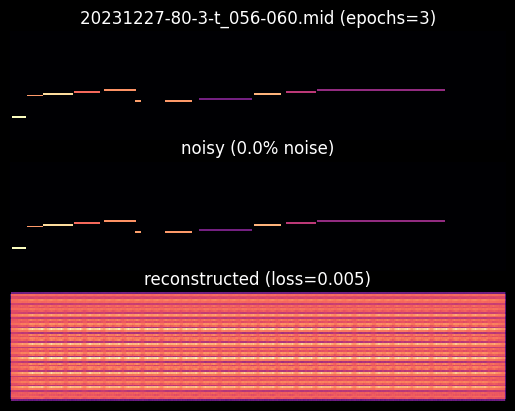

In [21]:
def test_image_reconstruction(net, loader):
    for batch in loader:
        # img = batch.view(32, 1, 28, 28)
        name, img = batch
        if TESTING:
            img = name[0]

        img_noisy = img + NOISE_FACTOR * torch.randn(img.shape)
        img_noisy = np.clip(img_noisy, 0.0, 1.0)
        img_noisy = img_noisy.to(device)
        outputs = net(img_noisy)
        outputs = outputs.cpu().data

        images = [
            img[0] if TESTING else inputset.format_image(input_dataset[name[0]]),
            img_noisy[0].cpu().data,
            outputs[0],
        ]
        titles = [
            f"{'original' if TESTING else name[0]} (epochs={NUM_EPOCHS})",
            f"noisy ({NOISE_FACTOR}% noise)",
            f"reconstructed (loss={train_loss[-1]:.03f})",
        ]

        plot_images(images, titles)
        break


test_image_reconstruction(model, trainLoader)

###